<a href="https://colab.research.google.com/github/CDFire/ProjectsInAI-ML/blob/main/HW2/ProjectsInAIHW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ttest_rel
import xgboost as xgb

# Task 1

In [87]:
#fetch dataset
dataset = pd.read_csv('data.txt')
X = dataset.drop(columns=['Occupancy']).copy()
X = X.drop(columns=['date'])
y = dataset['Occupancy']

non_numeric_columns = X.select_dtypes(include=['object']).columns

for column in non_numeric_columns:
    # Check if the column contains datetime-like strings
    try:
        X.loc[:, column] = pd.to_datetime(X[column], errors='coerce')  # Parse as datetime where possible
        # Convert datetime to numeric Unix timestamp
        X.loc[:, column] = X[column].apply(lambda x: x.timestamp() if pd.notnull(x) else None)
    except Exception:
        # If not datetime-like, label encode the column
        X.loc[:, column] = LabelEncoder().fit_transform(X[column].astype(str))

#encode y values into numeric representations
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

#split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)

1.1

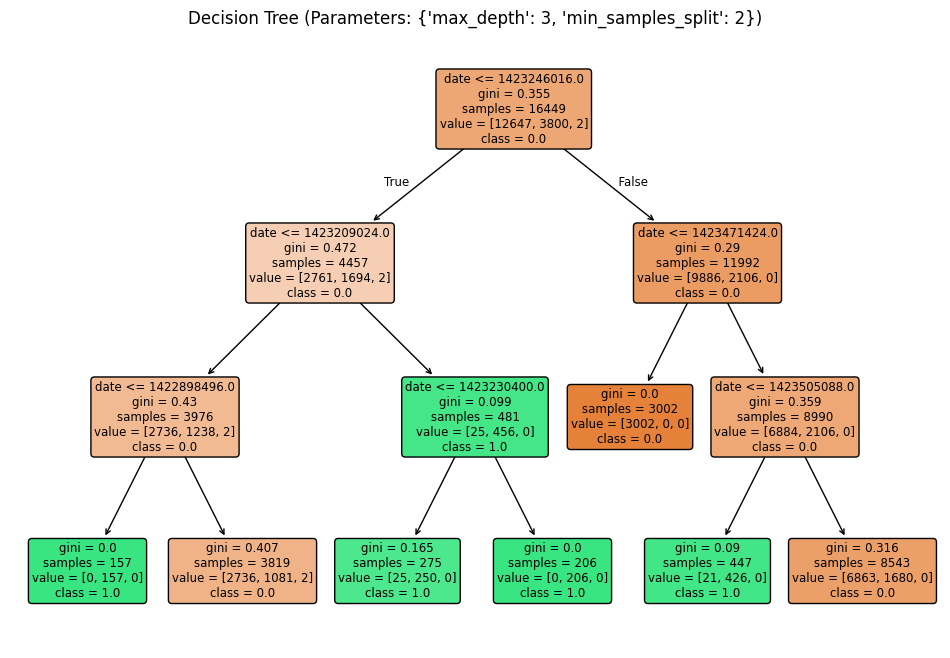

Accuracy with parameters {'max_depth': 3, 'min_samples_split': 2}: 83.18%



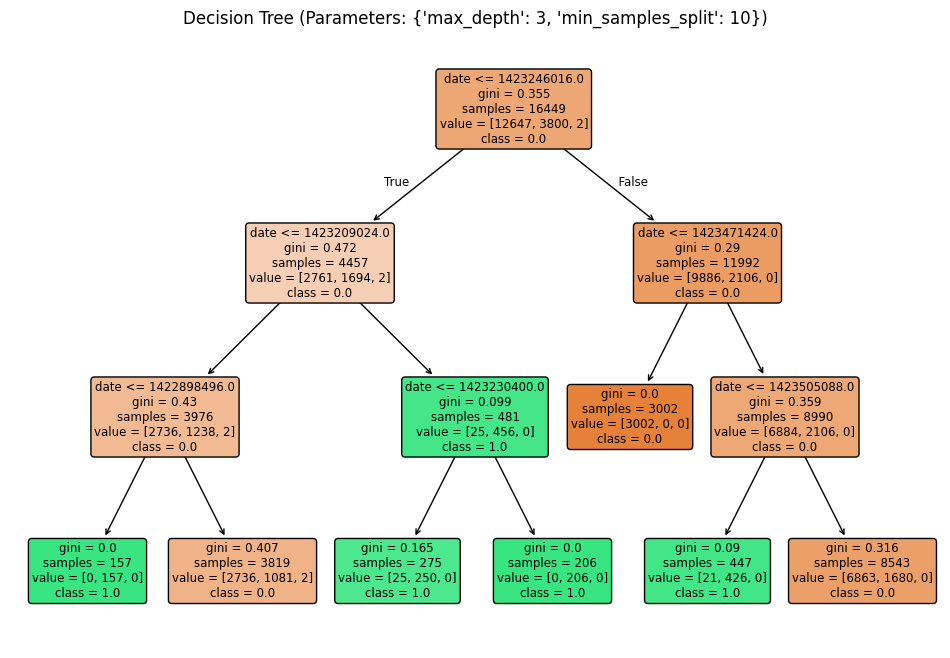

Accuracy with parameters {'max_depth': 3, 'min_samples_split': 10}: 83.18%



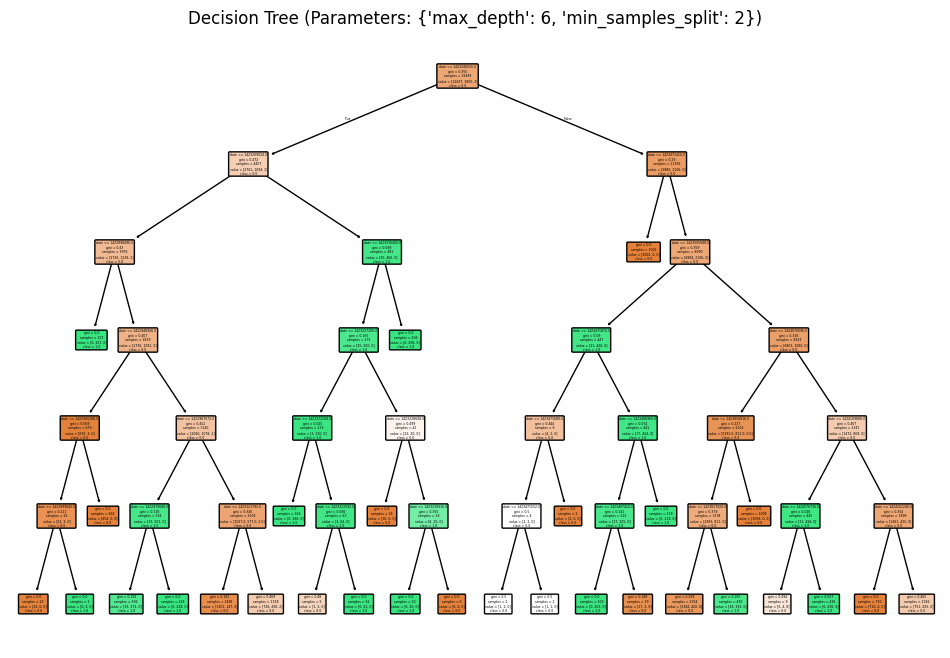

Accuracy with parameters {'max_depth': 6, 'min_samples_split': 2}: 90.66%



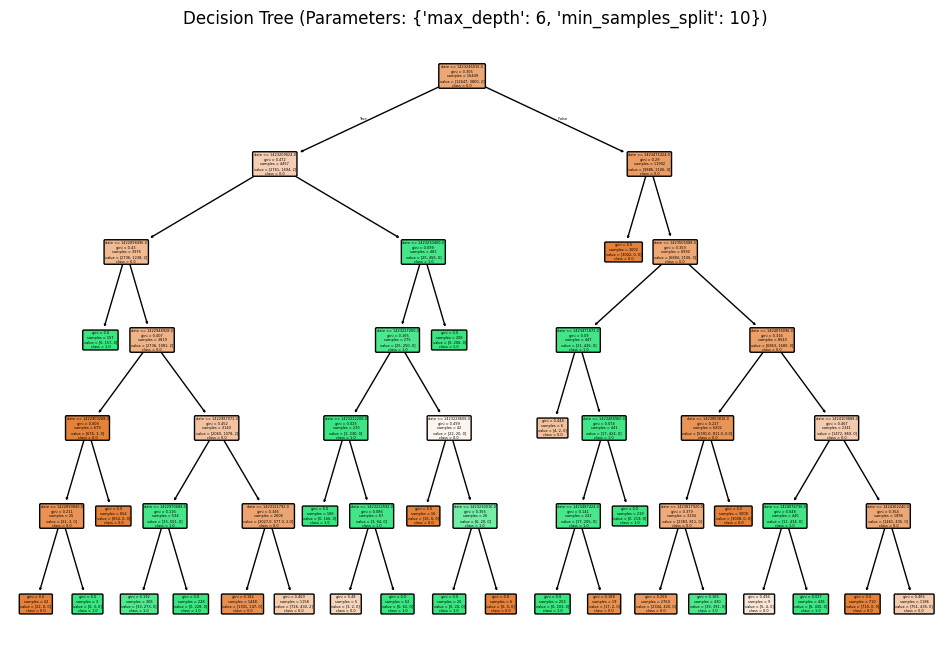

Accuracy with parameters {'max_depth': 6, 'min_samples_split': 10}: 90.66%



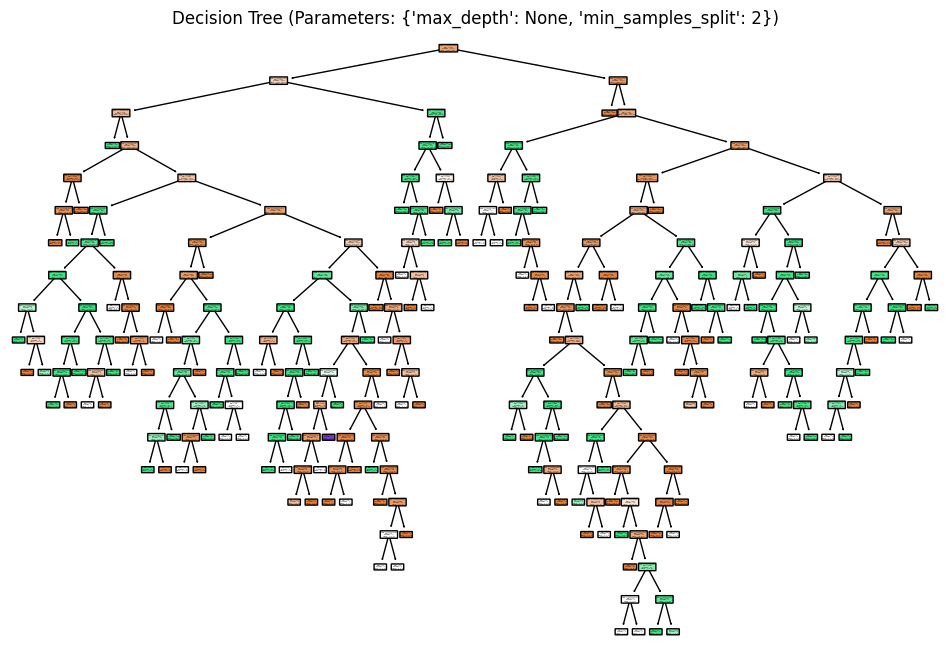

Accuracy with parameters {'max_depth': None, 'min_samples_split': 2}: 99.42%



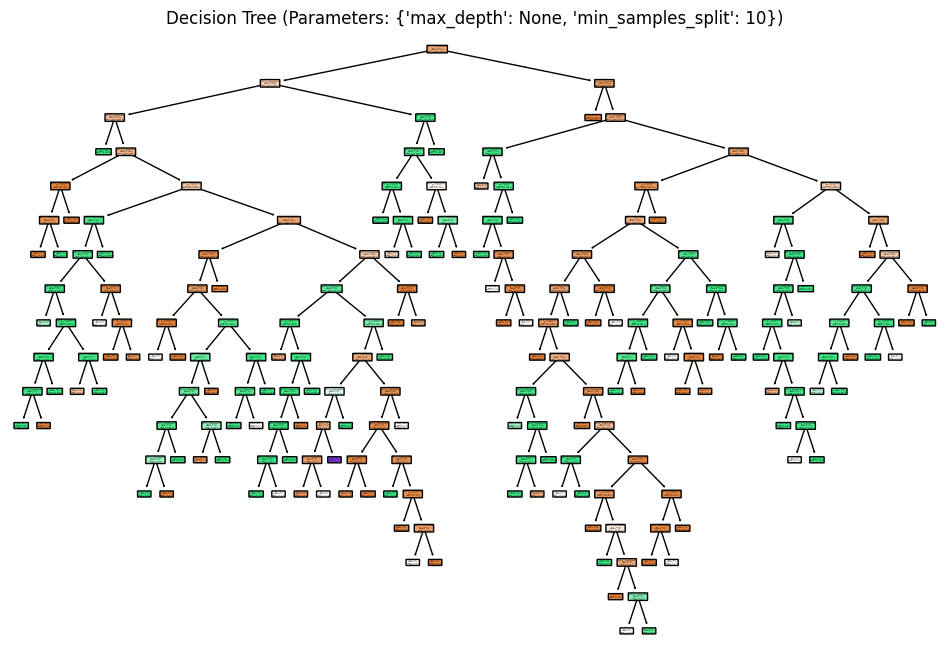

Accuracy with parameters {'max_depth': None, 'min_samples_split': 10}: 99.39%



In [126]:
params = [
    {"max_depth": 3, "min_samples_split": 2},
    {"max_depth": 3, "min_samples_split": 10},
    {"max_depth": 6, "min_samples_split": 2},
    {"max_depth": 6, "min_samples_split": 10},
    {"max_depth": None, "min_samples_split": 2},
    {"max_depth": None, "min_samples_split": 10}]

class_names = [str(cls) for cls in label_encoder.classes_]

for param in params:
    #train a decision tree with current parameter setting
    classifier = DecisionTreeClassifier(**param)
    classifier.fit(X_train, y_train)

    #plot the decision tree
    plt.figure(figsize=(12, 8))
    plot_tree( classifier, feature_names=X.columns, class_names=class_names, filled=True, rounded=True)
    plt.title(f"Decision Tree (Parameters: {param})")
    plt.show()

    #evaluate the classifiers
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with parameters {param}: {accuracy * 100:.2f}%\n")

Effect of max_depth:

	•	At max depth 3, the tree is shallow, limiting its ability to capture intricate patterns in the data..
	•	max_depth=6:
	•	At max depth 6 the tree becomes moderately deep, allowing it to model more complex relationships.
	•	At max depth none, the tree grows to its full depth and increases complexity greatly, leading to overfitting.

Effect of min_samples_split:

	•	min_samples_split=2:
	•	At min_samples_split 2, the tree is allowed to split even for very small subsets of data. This results in a highly granular tree structure, particularly when max_depth is None. This can lead to overfitting as the model becomes highly sensitive to individual data points.
	•	At min_samples_split 10, the tree enforces a minimum number of samples for splits, reducing the number of splits in the tree. The resulting trees are slightly less granular, reducing overfitting and improving generalizability.

For most datasets, a balance between depth and minimum samples split is important. Here we can see that increased depth and decreased minimum samples for a split can make the model more granular and accurate, but when taken too far causes severe overfitting.


1.2

Sensitivity Analysis measures how the variation in model output can be attributed to different input features. It identifies which features significantly impact a model’s predictions and decision boundaries. Sensitivity analysis is performed by:

	1. Introduce variations to one or more input features
	2. Observe the corresponding changes in the model’s output
	3. Quantify the sensitivity of a feature given these obervations

Citations:

National Research Council (US) Panel on Handling Missing Data in Clinical Trials. The Prevention and Treatment of Missing Data in Clinical Trials. Washington (DC): National Academies Press (US); 2010. 5, Principles and Methods of Sensitivity Analyses. Available from: https://www.ncbi.nlm.nih.gov/books/NBK209895/

ScienceDirect. (n.d.). Sensitivity analysis. In Topics in Biochemistry, Genetics and Molecular Biology. Retrieved January 27, 2025, from https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/sensitivity-analysis

In [145]:
#get subset of features that we are performing sensitivity analysis on
X_subset = X[['Temperature', 'Humidity']].copy()
y_subset = y_encoded.copy()
Features = ['Temperature', 'Humidity', 'Light']

#split the data
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2)

#train classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

#perturb one feature at a time
sensitivity_results = []
perturbations = np.linspace(-1, 1, 100)
for feature_idx in range(X_subset.shape[1]):
    original_values = X_test.iloc[:, feature_idx].values
    impacts = []

    for perturbation in perturbations:
        #perturb the feature values
        perturbed_values = original_values + perturbation
        X_perturbed = X_test.copy()
        X_perturbed.iloc[:, feature_idx] = perturbed_values

        #predict with perturbed features
        y_pred = classifier.predict(X_perturbed)
        impact = np.mean(y_pred != y_test)
        impacts.append(impact)

    #append results for this feature
    sensitivity_results.append((perturbations, impacts))

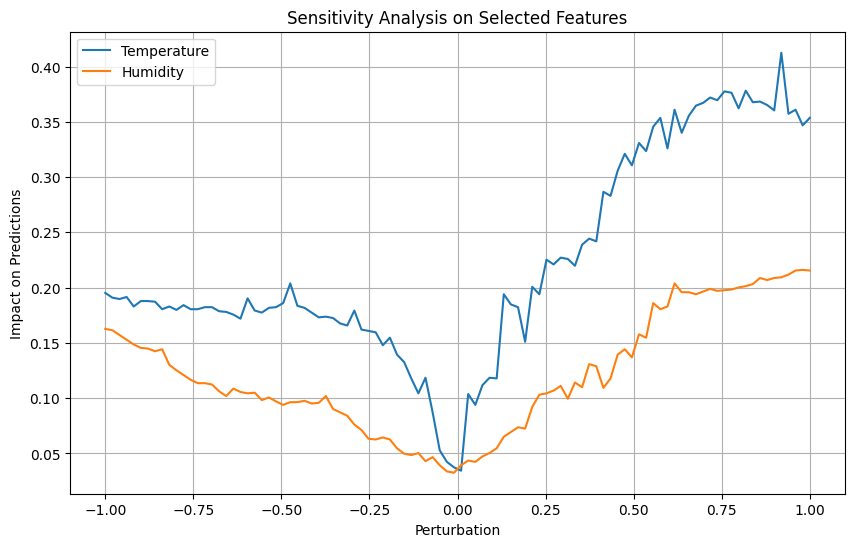

In [146]:
plt.figure(figsize=(10, 6))
for feature_idx in range(X_subset.shape[1]):
    perturbations, impacts = sensitivity_results[feature_idx]
    plt.plot(perturbations, impacts, label=f"{Features[feature_idx]}")
plt.xlabel("Perturbation")
plt.ylabel("Impact on Predictions")
plt.title("Sensitivity Analysis on Selected Features")
plt.legend()
plt.grid()
plt.show()

# Task 2

In [47]:
#random forest classifier
rf = RandomForestClassifier(n_estimators=100)

#gradient boosting classifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)

#folds for k-fold cross validation
fold_sizes = [5, 10, 15]

#function to evaluate models on different fold splits
def evaluate_model(model, X, y, splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    accuracies, precisions, f1_scores = [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #compute metrics(accuracy, precision and f1 score)
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    return np.mean(accuracies), np.mean(precisions), np.mean(f1_scores)

In [51]:
for fold_size in fold_sizes:
    print(f"Evaluating with {fold_size} folds:")
    rf_results = evaluate_model(rf, X, y, fold_size)
    gb_results = evaluate_model(gb, X, y, fold_size)

    print('Random Forest' + str(fold_size) + str(rf_results))
    print('Gradient Boosting' + str(fold_size) + str(gb_results))

Evaluating with 5 folds:
Random Forest5(0.994719330078446, 0.9947436191120802, 0.9947258193591629)
Gradient Boosting5(0.9937368307534052, 0.9937853590333324, 0.9937428740469783)
Evaluating with 10 folds:
Random Forest10(0.9948427066218477, 0.9948741533278621, 0.9948456676571631)
Gradient Boosting10(0.9950881053948539, 0.9951226300812802, 0.9950921089820935)
Evaluating with 15 folds:
Random Forest15(0.9955787513676242, 0.9956115128623257, 0.9955859598269405)
Gradient Boosting15(0.9943505512403192, 0.9943939924496351, 0.9943529799430546)


The ranking of algorithms does not change across metrics within the same fold configuration, as all metrics (Accuracy, Precision, F1-Score) show highly correlated results. dIncreasing the number of folds generally leads to more robust performance estimates, as more data is used for training in each iteration.	Random Forest benefits more consistently from higher folds, showing improvements across metrics at 15 folds. Gradient Boosting shows variability, slightly underperforming at 15 folds compared to its performance at 10 folds. In well-balanced datasets, Accuracy, Precision, and F1-Score tend to correlate, as seen here. If the dataset was imbalanced, F1-Score might highlight differences that Accuracy and Precision could mask.

Random Forest generally outperforms Gradient Boosting in this evaluation, especially at 5-fold and 15-fold configurations. Gradient Boosting performs marginally better at 10 folds, showing its strength in optimizing smaller folds. The rankings do not change significantly across metrics, as the dataset is balanced, and the algorithms perform consistently.


# Task 3

3.1 Confusion matrix

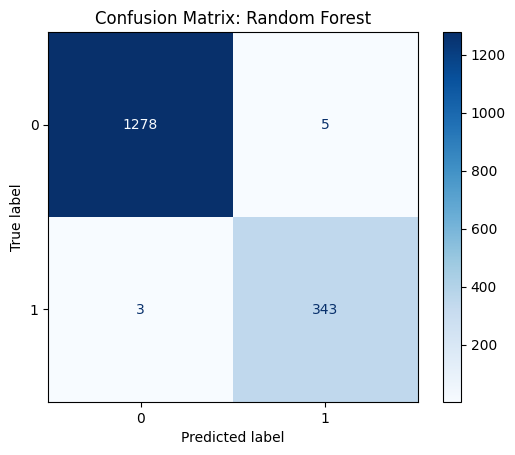

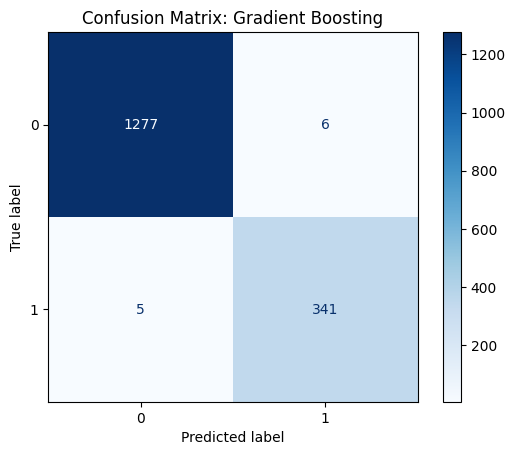

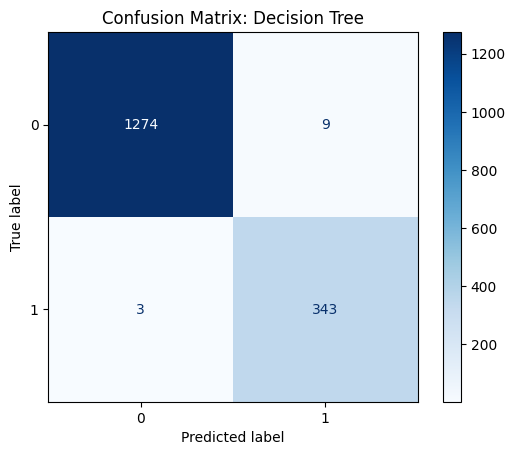

In [53]:
#set up data for models
skf = StratifiedKFold(n_splits=5, shuffle=True)
train_index, test_index = next(skf.split(X, y))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#train all three models
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
dt = DecisionTreeClassifier(max_depth=6).fit(X_train, y_train)

#predict using the models
y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)
y_pred_dt = dt.predict(X_test)

# Plot confusion matrices
for model_name, y_pred in [("Random Forest", y_pred_rf),
                           ("Gradient Boosting", y_pred_gb),
                           ("Decision Tree", y_pred_dt)]:
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

3.2 Paired T-tests

In [55]:
rf_scores, gb_scores, dt_scores = [], [], []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    dt.fit(X_train, y_train)

    rf_scores.append(accuracy_score(y_test, rf.predict(X_test)))
    gb_scores.append(accuracy_score(y_test, gb.predict(X_test)))
    dt_scores.append(accuracy_score(y_test, dt.predict(X_test)))

#perform paired t-tests
t_stat_rf_gb, p_value_rf_gb = ttest_rel(rf_scores, gb_scores)
t_stat_rf_dt, p_value_rf_dt = ttest_rel(rf_scores, dt_scores)
t_stat_gb_dt, p_value_gb_dt = ttest_rel(gb_scores, dt_scores)

print(f"Paired t-test (Random Forest vs Gradient Boosting): t={t_stat_rf_gb:.4f}, p={p_value_rf_gb:.4f}")
print(f"Paired t-test (Random Forest vs Decision Tree): t={t_stat_rf_dt:.4f}, p={p_value_rf_dt:.4f}")
print(f"Paired t-test (Gradient Boosting vs Decision Tree): t={t_stat_gb_dt:.4f}, p={p_value_gb_dt:.4f}")

Paired t-test (Random Forest vs Gradient Boosting): t=1.1770, p=0.3045
Paired t-test (Random Forest vs Decision Tree): t=3.1623, p=0.0341
Paired t-test (Gradient Boosting vs Decision Tree): t=1.8629, p=0.1359


3.3

Random Forest has low bias due to averaging predictions across multiple trees and low variance as bootstrapping reduces overfitting by introducing randomness.

Gradient Boosting has moderate bias as sequential training allows correction of errors and high variance due to its sensitivity to noisy data.

Decision Tree has high bias if the depth is too shallow and high variance when the depth is unrestricted, leading to overfitting.

The only statistically significant difference on this dataset is between Random Forest and Decision Tree. This indicates that Random Forest is better than Decision Tree on this dataset.


# Task 6000 Level

In [120]:
import warnings
warnings.filterwarnings("ignore")
xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

#define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.3, 0.7, 1.0],
}

best_params = None
best_score = 0

for lr in param_grid['learning_rate']:
    for depth in param_grid['max_depth']:
        for subsample in param_grid['subsample']:
            #set the parameters
            xgb_model.set_params(learning_rate=lr, max_depth=depth, subsample=subsample)

            #train the model
            xgb_model.fit(X_train, y_train)

            #evaluate on the test set
            y_pred = xgb_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            print(f"Params: learning_rate={lr}, max_depth={depth}, subsample={subsample} -> Accuracy: {accuracy:.4f}")

            #update best parameters if current accuracy is better
            if accuracy > best_score:
                best_score = accuracy
                best_params = {'learning_rate': lr, 'max_depth': depth, 'subsample': subsample}

print(f"\nBest Parameters: {best_params}")
print(f"Best Accuracy: {best_score:.4f}")


Params: learning_rate=0.01, max_depth=3, subsample=0.3 -> Accuracy: 0.9908
Params: learning_rate=0.01, max_depth=3, subsample=0.7 -> Accuracy: 0.9914
Params: learning_rate=0.01, max_depth=3, subsample=1.0 -> Accuracy: 0.9939
Params: learning_rate=0.01, max_depth=6, subsample=0.3 -> Accuracy: 0.9926
Params: learning_rate=0.01, max_depth=6, subsample=0.7 -> Accuracy: 0.9920
Params: learning_rate=0.01, max_depth=6, subsample=1.0 -> Accuracy: 0.9914
Params: learning_rate=0.01, max_depth=9, subsample=0.3 -> Accuracy: 0.9926
Params: learning_rate=0.01, max_depth=9, subsample=0.7 -> Accuracy: 0.9920
Params: learning_rate=0.01, max_depth=9, subsample=1.0 -> Accuracy: 0.9914
Params: learning_rate=0.05, max_depth=3, subsample=0.3 -> Accuracy: 0.9939
Params: learning_rate=0.05, max_depth=3, subsample=0.7 -> Accuracy: 0.9932
Params: learning_rate=0.05, max_depth=3, subsample=1.0 -> Accuracy: 0.9939
Params: learning_rate=0.05, max_depth=6, subsample=0.3 -> Accuracy: 0.9945
Params: learning_rate=0.0

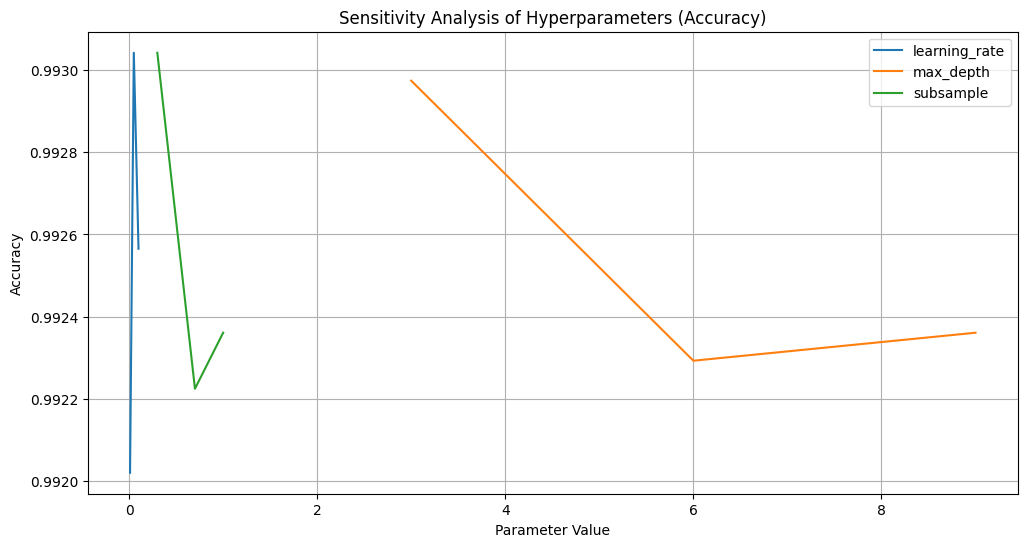

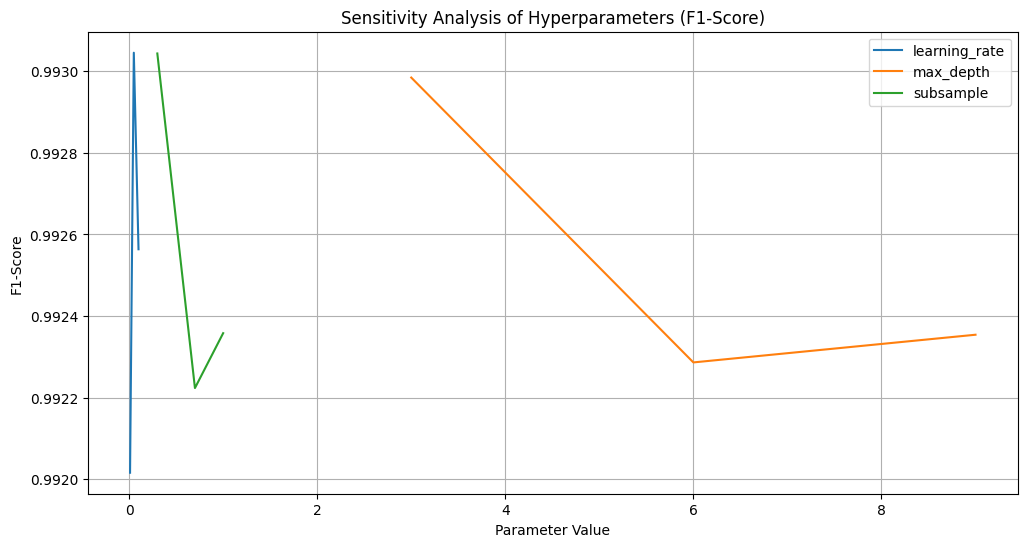

In [121]:
results = []
for lr in param_grid['learning_rate']:
    for depth in param_grid['max_depth']:
        for subsample in param_grid['subsample']:
            xgb_model.set_params(learning_rate=lr, max_depth=depth, subsample=subsample)
            xgb_model.fit(X_train, y_train)
            y_pred = xgb_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            results.append({ 'learning_rate': lr, 'max_depth': depth, 'subsample': subsample, 'accuracy': accuracy, 'f1_score': f1
            })

#convert results to a dataframe
results_df = pd.DataFrame(results)

#plot sensitivity analysis for accuracy
plt.figure(figsize=(12, 6))
for param in ['learning_rate', 'max_depth', 'subsample']:
    grouped_data = results_df.groupby(param)['accuracy'].mean()
    plt.plot(grouped_data.index, grouped_data.values, label=param)
plt.xlabel("Parameter Value")
plt.ylabel("Accuracy")
plt.title("Sensitivity Analysis of Hyperparameters (Accuracy)")
plt.legend()
plt.grid()
plt.show()

#plot sensitivity analysis for f1-Score
plt.figure(figsize=(12, 6))
for param in ['learning_rate', 'max_depth', 'subsample']:
    grouped_data = results_df.groupby(param)['f1_score'].mean()
    plt.plot(grouped_data.index, grouped_data.values, label=param)
plt.xlabel("Parameter Value")
plt.ylabel("F1-Score")
plt.title("Sensitivity Analysis of Hyperparameters (F1-Score)")
plt.legend()
plt.grid()
plt.show()

From the sensitivity analysis and visualizations we see that lower learning rates result in slightly lower accuracy but more stable performance across different depths and subsampling rates. Medium learning rates achieve the best overall accuracy. Higher learning rates lead to slightly reduced performance. Shallower trees generally achieve good accuracy but lack the complexity to capture intricate patterns. Deeper trees provide the best performance in combination with the right learning rate and subsampling. Very deep trees tend to perform worse, potentially due to overfitting and poorer generalization. Lower subsampling rates achieve the best accuracy when combined with optimal learning rates and tree depths. Full subsampling generally results in slightly lower accuracy, suggesting that reduced subsampling helps in regularization.